# A/B Testing: Conversion Rate Optimization

In this notebook, we’ll go through the process of analyzing an A/B experiment: from formulating a hypothesis, testing it, to interpreting the results.

**Scenario:** Imagine you work on the product team at a medium-sized online e-commerce business. The UX designer has created a new product page design with the hope of increasing the conversion rate. The product manager (PM) told you that the current conversion rate is around 13% on average throughout the year. The team considers the new design a success if it increases the conversion rate to 15% (a 2% increase).

Before rolling out the change to all users, the team wants to test it on a small subset. You suggest running an A/B test on this subset.

## Designing Our Experiment

### Formulating a Hypothesis
Since we do not know if the new design will perform better, worse, or the same as the current design, we will choose a **two-tailed test**:

$$
H_0: p = p_0
$$
$$
H_1: p \neq p_0
$$

We set a **confidence level** of 95%:

$$
\alpha = 0.05
$$

The $\alpha$ value is the threshold we use to determine significance: if the probability of observing a result as extreme or more (the p-value) is lower than $\alpha$, we reject the null hypothesis.

### Choosing the Variables
We need two groups for the test:

- **Control Group:** Shown the old design.
- **Treatment (Experimental) Group:** Shown the new design.

The **independent variable** is the design version (old vs. new). We include two groups to control for external factors like seasonality.

The **dependent variable** is the conversion rate, which can be coded per user session as a binary variable:

- 0 — User did not purchase during the session.
- 1 — User purchased during the session.

### Choosing a Sample Size
Since we will not test the entire user base, the observed conversion rates are estimates of the true population rates.

- **Larger sample sizes** → more precise estimates (smaller confidence intervals) → higher likelihood of detecting a difference if one exists.
- **Smaller sample sizes** → cheaper and easier to implement but less precise.

Sample size is estimated using **Power Analysis**, which depends on:

- **Power of the test ($1 - \beta$):** Probability of detecting a true difference if one exists (commonly set to 0.8).  
- **Alpha ($\alpha$):** Significance level (set at 0.05).  
- **Effect size:** Expected difference between conversion rates (here, 2%, from 13% to 15%).

We can use these values to calculate the minimum number of users needed in each group to detect a significant effect.

In [21]:
# Imports
import pandas as pd
import statsmodels.stats.api as sms
from math import ceil

# Expected proportions in control and treatment groups
p_control = 0.13
p_treatment = 0.15

# Calculate Cohen's h effect size for proportions
effect_size = sms.proportion_effectsize(p_control, p_treatment)
print(f"Effect size (Cohen's h): {effect_size:.4f}")

# Calculate required sample size per group
power_analysis = sms.NormalIndPower()
required_n = power_analysis.solve_power(
    effect_size=effect_size, 
    power=0.8,      # Desired statistical power
    alpha=0.05,     # Significance level
    ratio=1         # Equal sample sizes in both groups
)

# Round up to next whole number
required_n = ceil(required_n)
print(f"Required sample size per group: {required_n}")


Effect size (Cohen's h): -0.0577
Required sample size per group: 4720


We’d need **at least 4720 observations for each group.**

Having set the **power parameter** to 0.8 means that if there is an actual difference in conversion rates between our designs—assuming the difference is the one we estimated (13% vs. 15%)—we have approximately an 80% chance of detecting it as statistically significant in our test, given the sample size we calculated.

## Collecting and Preparing the Data

Since we’ll use a dataset sourced online to simulate this scenario, we will:

1. Load the dataset.
2. Read the data into a pandas DataFrame.
3. Check and clean the data as needed.
4. Randomly sample $n = 4{,}720$ rows from the DataFrame for each group.*

**Note:** Normally, step 4 would not be necessary; it is included here purely for the sake of the exercise.


In [22]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [24]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


There are **294478 rows** in the DataFrame, each representing a user session, as well as **5 columns**:

- user_id - The user ID of each session
- timestamp - Timestamp for the session
- group - Which group the user was assigned to for that session {control, treatment}
- landing_page - Which design each user saw on that session {old_page, new_page}
- converted - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

Before we go ahead and sample the data to get our subset, let’s make sure there are no users that have been sampled multiple times.

In [25]:
# Count how many sessions each user has
session_counts = df['user_id'].value_counts()

# Count users with more than one session
multi_users = (session_counts > 1).sum()

print(f"There are {multi_users} users that appear multiple times in the dataset.")

There are 3894 users that appear multiple times in the dataset.


There are, in fact, 3894 users that appear more than once. Since the number is pretty low, we’ll go ahead and remove them from the DataFrame to avoid sampling the same users twice.

In [26]:
# Identify users with more than one session
users_to_drop = session_counts[session_counts > 1].index

# Remove these users from the dataset
df = df[~df['user_id'].isin(users_to_drop)]

print(f"The updated dataset now has {df.shape[0]} entries.")


The updated dataset now has 286690 entries.


## Sampling

Now that our DataFrame is nice and clean, we can proceed and sample $n=4720$ entries for each of the groups. We can use pandas` DataFrame.sample()` method to do this, which will perform Simple Random Sampling for us.

Note: We’ve set $\text{random\_state}=22$ so that the results are reproducible.

In [27]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [28]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [29]:
ab_test['group'].value_counts()

group
control      4720
treatment    4720
Name: count, dtype: int64

## Visualising the results

The first thing we can do is to calculate some basic statistics to get an idea of what our samples look like.

In [30]:
conversion_rates = ab_test.groupby('group')['converted'].agg(["mean", 'std', 'sem'])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


Judging by the stats above, it does look like **our two designs performed very similarly**, with our new design performing slightly better, approx. **12.3% vs. 12.6% conversion rate**.

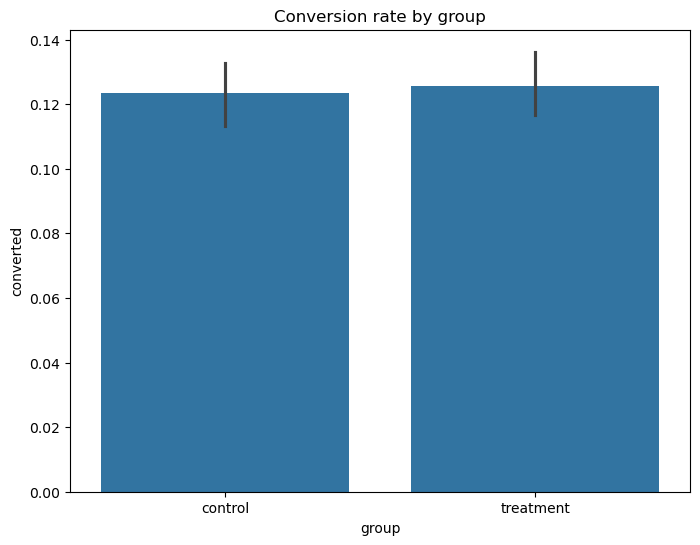

In [31]:
# Plotting the data will make these results easier to grasp:
plt.figure(figsize=(8,6))
sns.barplot(x='group', y='converted', data=ab_test, errorbar=('ci', 95))
plt.title('Conversion rate by group')
plt.show()

The conversion rates for our groups are indeed very close. Also note that the conversion rate of the control group is lower than what we would have expected given what we knew about our avg. conversion rate (12.3% vs. 13%). This goes to show that there is some variation in results when sampling from a population.

So… the treatment group's value is higher. **Is this difference statistically significant?**

## Testing the hypothesis

The last step of our analysis is testing our hypothesis. Since we have a very large sample, we can use the normal approximation for calculating our p-value (i.e. z-test).

In [32]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_con_succ = control_results.sum()

n_treat = treatment_results.count()
n_treat_succ = treatment_results.sum()

successes = [n_con_succ, n_treat_succ]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


## Drawing Conclusions

Since our **p-value = 0.732** is well above our threshold of **α = 0.05**, we **cannot reject the Null hypothesis $H_0$**. This means that the new design did **not perform significantly differently** (let alone better) than the old design.

Additionally, if we look at the **confidence interval** for the treatment group ([0.116, 0.135] or 11.6%–13.5%), we notice that:

- It **includes** our baseline conversion rate of 13%.
- It **does not include** our target value of 15% (the 2% uplift we were hoping for).

This indicates that the true conversion rate of the new design is more likely to be **similar to the baseline** rather than the 15% target. In other words, the new design is **unlikely to be an improvement** over the old one, and unfortunately, we are **back to the drawing board**!
